In [62]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/walmart-sales/Walmart_Sales.csv


In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.preprocessing import KBinsDiscretizer , StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score ,KFold

In [64]:
df = pd.read_csv('/kaggle/input/walmart-sales/Walmart_Sales.csv')

In [65]:
print(df.info())
print(df.columns)
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB
None
Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment'],
      dtype='object')
(6435, 8)


The data contains the following columns:

1. `Store:` Store number
2. `Date:` Sales week start date
3. `Weekly_Sales:` Sales
4. `Holiday_Flag:` Mark on the presence or absence of a holiday
5. `Temperature:` Air temperature in the region
6. `Fuel_Price:` Fuel cost in the region
7. `CPI:` Consumer price index
8. `Unemployment:` Unemployment rate
df.isnull().sum()

In [66]:
df.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [67]:
df['Date'] = pd.to_datetime(df['Date'], format="%d-%m-%Y", dayfirst=True)

df['year'] = df['Date'].dt.year
df['quarter'] = df['Date'].dt.quarter
df['month'] = df['Date'].dt.month

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
 8   year          6435 non-null   int32         
 9   quarter       6435 non-null   int32         
 10  month         6435 non-null   int32         
dtypes: datetime64[ns](1), float64(5), int32(3), int64(2)
memory usage: 477.7 KB


In [68]:
df = df.drop(columns='Date')

In [69]:
df.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,quarter,month
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,2010,1,2
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,2010,1,2
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,2010,1,2
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,2010,1,2
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,2010,1,3


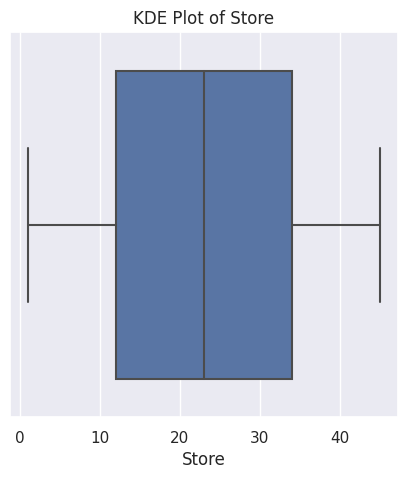

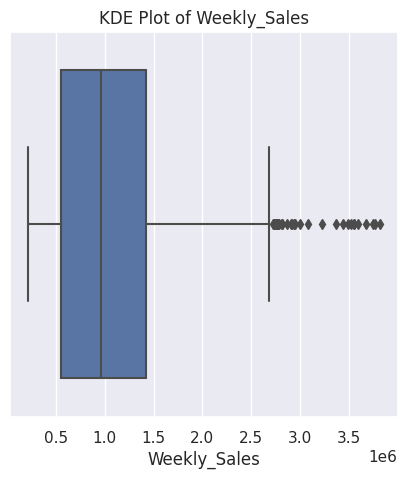

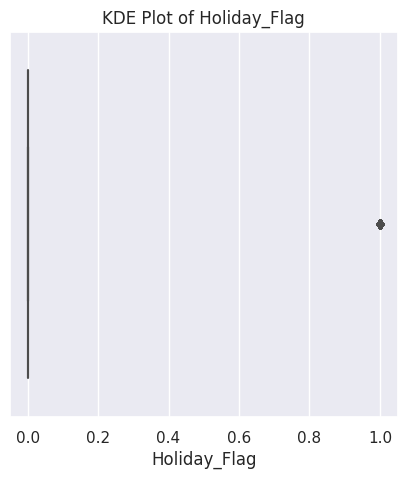

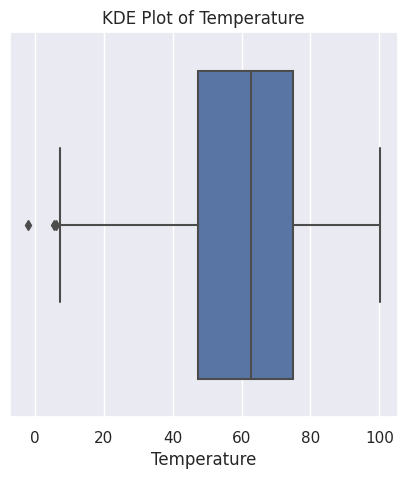

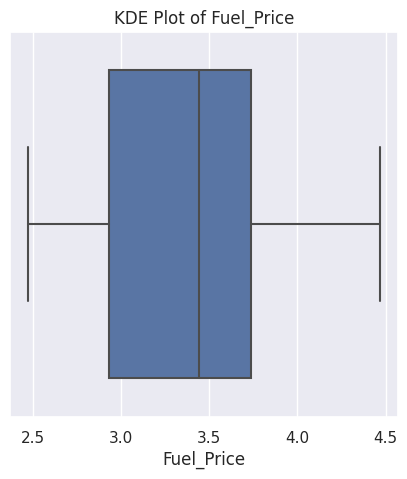

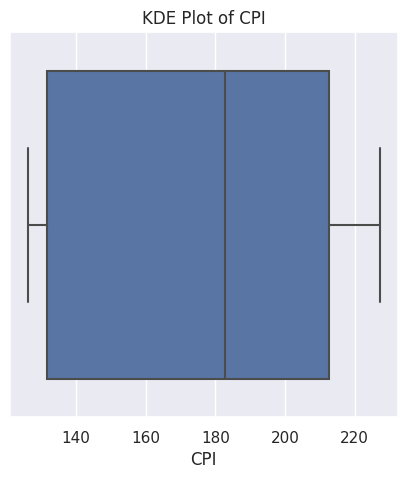

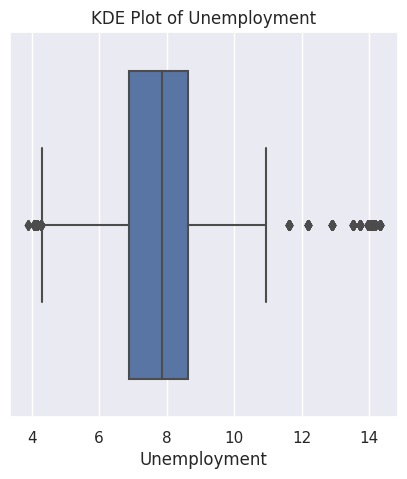

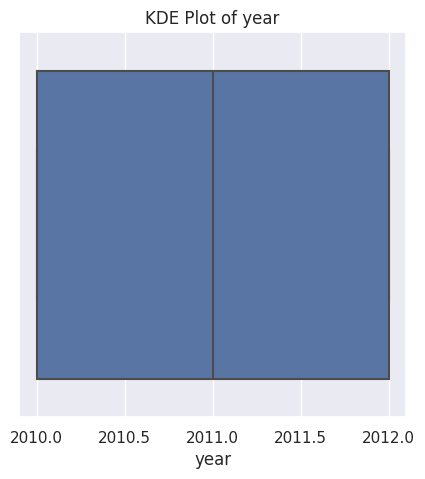

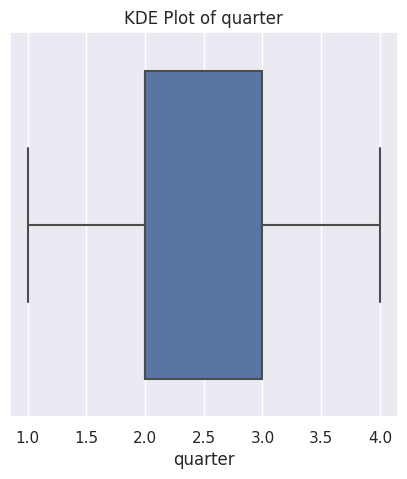

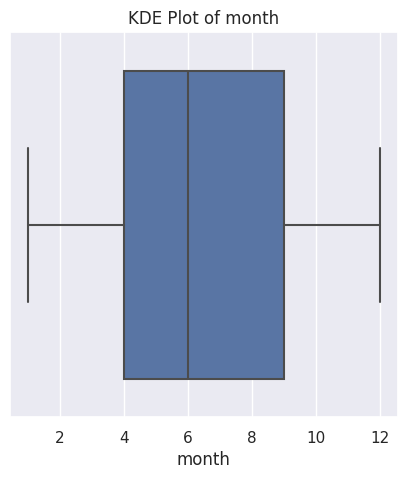

In [70]:
for i in df.columns:
    plt.figure(figsize=(5, 5))
    sns.boxplot(x=df[i])
    plt.title(f'KDE Plot of {i}')
    plt.xlabel(i)
    plt.show()

In [71]:
print("max value", df['Weekly_Sales'].max())
print("min value", df['Weekly_Sales'].min())
print("highest allowed", df['Weekly_Sales'].mean() + 3*df['Weekly_Sales'].std())
print("lowest allowed", df['Weekly_Sales'].mean() - 3*df['Weekly_Sales'].std())

max value 3818686.45
min value 209986.25
highest allowed 2740064.743722864
lowest allowed -646134.9885993209


In [72]:
new_df = df[(df['Weekly_Sales'] < 2740064.743722864) & (df['Weekly_Sales'] > -646134.9885993209)]

new_df

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,quarter,month
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,2010,1,2
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,2010,1,2
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,2010,1,2
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,2010,1,2
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,2010,1,3
...,...,...,...,...,...,...,...,...,...,...
6430,45,713173.95,0,64.88,3.997,192.013558,8.684,2012,3,9
6431,45,733455.07,0,64.89,3.985,192.170412,8.667,2012,4,10
6432,45,734464.36,0,54.47,4.000,192.327265,8.667,2012,4,10
6433,45,718125.53,0,56.47,3.969,192.330854,8.667,2012,4,10


<Axes: xlabel='Weekly_Sales'>

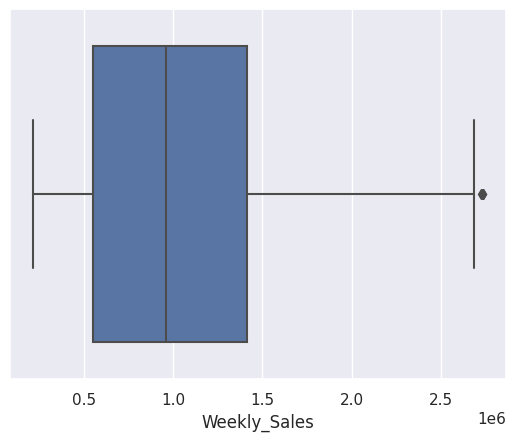

In [73]:
sns.boxplot(x=new_df['Weekly_Sales'])

In [74]:
features = ['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'year', 'month', 'quarter']
x = new_df[features]
y = new_df['Weekly_Sales']

In [75]:
scale = StandardScaler()
scaled_x = scale.fit_transform(x)

In [76]:
scaled_x = pd.DataFrame(scaled_x,columns=x.columns)

In [77]:
scaled_x

,Store,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,quarter
0,-1.697366,-0.271926,-1.001713,-1.713389,1.002766,0.055598,-1.213552,-1.371280,-1.382257
1,-1.697366,3.677473,-1.208027,-1.765607,1.006471,0.055598,-1.213552,-1.371280,-1.382257
2,-1.697366,-0.271926,-1.130931,-1.839583,1.007664,0.055598,-1.213552,-1.371280,-1.382257
3,-1.697366,-0.271926,-0.767166,-1.737322,1.008439,0.055598,-1.213552,-1.371280,-1.382257
4,-1.697366,-0.271926,-0.774224,-1.598073,1.009214,0.055598,-1.213552,-1.061243,-1.382257
...,...,...,...,...,...,...,...,...,...
6400,1.689794,-0.271926,0.223686,1.387073,0.517899,0.363315,1.295017,0.798982,0.491469
6401,1.689794,-0.271926,0.224229,1.360964,0.521884,0.354265,1.295017,1.109019,1.428332
6402,1.689794,-0.271926,-0.341507,1.393601,0.525870,0.354265,1.295017,1.109019,1.428332
6403,1.689794,-0.271926,-0.232920,1.326152,0.525961,0.354265,1.295017,1.109019,1.428332


In [78]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Perform 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, scaled_x, y, cv=kf, scoring='r2')

# Print cross-validation results
print("Cross-validation R-squared scores:", cv_scores)
print(f"Mean R-squared score: {cv_scores.mean():.4f}")
print(f"Standard deviation of R-squared scores: {cv_scores.std():.4f}")


Cross-validation R-squared scores: [0.95154174 0.95028379 0.95932361 0.95107528 0.95464539]
Mean R-squared score: 0.9534
Standard deviation of R-squared scores: 0.0033


In [79]:
x_train , x_test , y_train , y_test = train_test_split(scaled_x,y,test_size=0.2,random_state=365)

In [80]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(x_train,y_train)
y_pred = rf_model.predict(x_test)
r2_score(y_test,y_pred)

0.9602243639508954